# Photo double-ionization of water molecules

The following is a condensed version of my dissertation data analysis. I recreate it here using python to perform exploration and plotting of the data, mostly as an exercise in using python and jupyter notebooks.

The experiment is as follows: a 57 eV linearly polarized photon strikes an internally cold (electronic ground state, nearly or exactly vibrational ground state) water molecule. The photon is absorbed, two electrons are promoted to the continuum, and the dication H$_2$O$^{2+}$ remains. This dication is unstable and dissociates. While there are several ways this can happen, I will focus on the pathway that leads to a neutral oxygen and two H$^+$ fragments. Our task is to inspect the kinematics of the particles to learn whatever we can about the photo double-ionization process.

### Preliminary Steps

Initial data analysis is performed with custom C++ code called "LMF2ROOT", which converts our raw list mode files (lmf) to ROOT files. Data cleaning techniques like detector alignment, coincidence counts, and particle reconstruction are done with this code. The end result is a ROOT file with a few hundred thousand "good" events, with particle momenta transformed into a "fixed-body" frame.

<img src="recoil_frame.png" style="width: 500px;"/>
<div align="center">
    <font size=6>Fig. 1</font>
</div>

The momenta of the neutral oxygen fragment can be inferred via the principle of conservation of momentum. We'll do this in python by wrapping a pandas dataframe in a Data class that offers a few helper methods for adding a new particle, as well as generating the kinetic energy of each particle.

In [63]:
# @hidden_cell

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

class Data():
    def __init__(self,csv_filename):
        self.data = pd.read_csv(csv_filename)
        for particle in range(1,self.data.loc[0,'n_recoil']+1):
            self.data['rke_'+str(particle)] = 27.2116*(
                                    np.square(self.data['rpx_'+str(particle)]) + 
                                    np.square(self.data['rpy_'+str(particle)]) +
                                    np.square(self.data['rpz_'+str(particle)])
                                    )/(2 * self.data['mass_'+str(particle)] * 1836)
        for electron in range(1,self.data.loc[0,'n_electron']+1):
            self.data['eke_'+str(electron)] = 27.2116*(
                                    np.square(self.data['epx_'+str(electron)]) + 
                                    np.square(self.data['epy_'+str(electron)]) +
                                    np.square(self.data['epz_'+str(electron)])
                                    )/(2)
    def add_neutral_particle(self,first_particle,second_particle,mass):
        self.data['n_recoil']+=1
        newParticleID = self.data.loc[0,'n_recoil']
        self.data['mass_'+str(newParticleID)] = mass
        self.data['rpx_'+str(newParticleID)] = -(self.data['rpx_'+str(first_particle)] + self.data['rpx_'+str(second_particle)])
        self.data['rpy_'+str(newParticleID)] = -(self.data['rpy_'+str(first_particle)] + self.data['rpy_'+str(second_particle)])
        self.data['rpz_'+str(newParticleID)] = -(self.data['rpz_'+str(first_particle)] + self.data['rpz_'+str(second_particle)])
        self.data['rke_'+str(newParticleID)] = 27.2116*(
                                np.square(self.data['rpx_'+str(newParticleID)]) +
                                np.square(self.data['rpy_'+str(newParticleID)]) +
                                np.square(self.data['rpz_'+str(newParticleID)])
                                )/(2*16*1836)
        self.generate_ker()
        self.generate_ee_sum()
    def generate_ker(self):
        self.data['ker'] = 0
        for particle in range(1,self.data.loc[0,'n_recoil']+1):
            self.data['ker'] += self.data['rke_'+str(particle)]
    def generate_ee_sum(self):
        self.data['ee_sum'] = 0
        for particle in range(1,self.data.loc[0,'n_electron']+1):
            self.data['ee_sum'] += self.data['eke_'+str(particle)]
    def set_coordinate_system(self,cs):
        if type(cs) == type(Coordinate_System()):
            self.coordinate_system = cs
            
data = Data('raw_particle_data.csv')
data.add_neutral_particle(1,2,16)

### Initial Data Analysis

Now that the data is in a dataframe (inside our wrapper Data class) we can make some plots and see what's what. A quick look at the head of the dataframe is a good place to start.

In [3]:
data.data.head()

,n_recoil,n_electron,mass_1,rpx_1,rpy_1,rpz_1,mass_2,rpx_2,rpy_2,rpz_2,...,rke_2,eke_1,eke_2,mass_3,rpx_3,rpy_3,rpz_3,rke_3,ker,ee_sum
0,3,2,1,0.323429,3.24364,4.54473,1,21.309000,-12.39840,3.50554,...,4.595163,0.222592,4.412788,16,-21.632429,9.15476,-8.05027,0.285575,5.112543,4.635380
1,3,2,1,-2.099740,-16.53060,19.25030,1,3.123290,2.76647,-11.93840,...,1.185199,0.867412,9.832358,16,-1.023550,13.76413,-7.31190,0.112994,6.102046,10.699770
2,3,2,1,49.528100,-2.97744,6.64621,1,0.281147,1.98228,-14.78370,...,1.649342,3.210305,12.724118,16,-49.809247,0.99516,8.13749,1.180212,21.400951,15.934423
3,3,2,1,22.091200,-26.79950,21.34720,1,0.532190,2.06470,-5.46266,...,0.254826,7.782421,9.247106,16,-22.623390,24.73480,-15.88454,0.637284,13.208007,17.029527
4,3,2,1,6.299250,-4.50968,-4.12404,1,7.149960,-18.59860,-25.48290,...,7.754476,1.948459,5.786778,16,-13.449210,23.10828,29.60694,0.737094,9.062373,7.735237


A typical starting point in molecular dissociation experiments is the energy correlation plot, which is the sum of photoelectron energies against the sum of the kinetic energies of the recoil particles (atoms, molecules, and ionic versions of both).

But first, we'll define a traditional COLTRIMS color pallette for use in our 2d histograms.

In [4]:
cdict = {'red':   ((0.0, 1.0,1.0),
                   (0.001, 0.5,0.5),
                   (0.3, 0.0,0.0),
                   (0.7, 0.99,0.99),
                   (1.0, .99,.99)),

         'green': ((0.0, 1.0,1.0),
                   (0.001, 0.99,0.99),
                   (0.3, 0.0,0.0),
                   (0.7, 0.0,0.0),
                   (1.0, .99,.99)),

         'blue':  ((0.0, 1.0,1.0),
                   (0.001, .99,.99),
                   (0.3, .99,.99),
                   (0.7, 0.0,0.0),
                   (1.0, 0.0,0.0))}

colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]  # R -> G -> B
cmap = LinearSegmentedColormap.from_list('base colors',colors,100)
coltrims = LinearSegmentedColormap('coltrims',cdict)

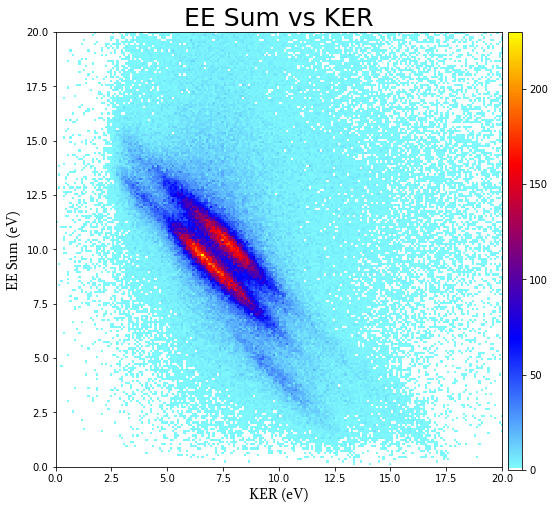

In [5]:
fig, ax = plt.subplots()
cax = fig.add_axes([.91, 0.12, 0.025, .76])
fig.set_figheight(8)
fig.set_figwidth(8)
im = ax.hist2d(data.data['ker'],data.data['ee_sum'],bins=200,cmap=coltrims,range=[[0,20],[0,20]])
fig.colorbar(im[3], cax=cax, orientation='vertical')
ax.set_xlabel('KER (eV)',fontname='sylfaen',fontsize=15)
ax.set_ylabel('EE Sum (eV)',fontname='sylfaen',fontsize=15)
ax.set_title('EE Sum vs KER',fontsize=25);

Features are immediately visible: three diagonal stripes with slope near -1. Such a slope makes sense, given the requirement that energy is conserved among the constituent particles for a given breakup. What are the three features, though? Let's take a look at a 1D histogram of the total energy.

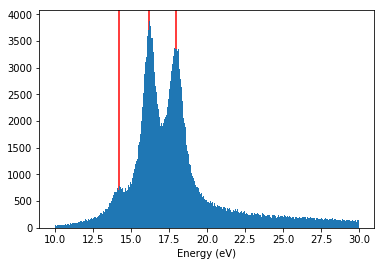

In [6]:
plt.axvline(x=14.2,color='red',zorder=0)
plt.axvline(x=16.2,color='red',zorder=0)
plt.axvline(x=18.0,color='red',zorder=0)
plt.hist(data.data['ker']+ data.data['ee_sum'],400,label='data',range=[10,30],zorder=1);
plt.xlabel('Energy (eV)');

There they are again - three features in total energy. These features correspond to *different* amounts of total energy distributed among the constituent particles following the photo double ionization. If energy is conserved, how is this possible? The only explanation is that some of the energy deposited in the molecule by the absorbed photon is being hidden from us. Let's consider the particles in the reaction:

* 2 electrons
* 2 H$^+$ ions
* 1 oxygen atom

Electrons have no internal structure - no way to hide energy there. H$^+$ ions *do* have internal structure - specifically, protons are made of quarks - but the energy scale doesn't fit. That leaves the neutral oxygen fragment.

The National Institute of Standards and Technology (NIST) keeps tabulated atomic energy level data on it's website. A quick look at the table for neutral oxygen yields the following information:

|Electron Config. | Term | J | Energy  |
|-----------------|------|---|-------  |
|2s$^2$2p$^4$     |  3P  | 2 |0.0000000|
|       "         |   "  | 1 |0.0196224|    	   	  
|       "         |   "  | 0 |0.0281416|
|2s$^2$2p$^4$     |    1D| 2 |1.9673641|    	   	  
|2s$^2$2p$^4$     |    1S| 0 |4.1897463|

The vertical lines are placed by visual inspection of the peak values for each feature, as a guide for the eye. If the features correspond to different oxygen terms, we would expect the largest total energy (rightmost peak) to correspond to the oxygen term with the *least* internal energy, i.e. the $^3$P term. Similarly, the central peak should correspond to the $^1$D term and the leftmost peak to the $^1$S term. The energy difference between states is on the order of $\sim$2 eV, which is reflected in the placement of the red lines.

Calculations for all energetically possible dication surfaces were conducted by our theoretical collaborators. A slice of those potential energy surfaces where both O-H$^+$ bond lengths are equal and the angle $\beta$ is 104.5$^o$ is shown below.

<img src="3bodyPotential.png" style="width: 500px;"/>
<div align="center">
    <font size=6>Fig. 2</font>
</div>

These dication states (e.g. $^1$A$_1$, $^3$B$_2$, etc) correspond to particular combinations of valence (bonding) electrons promoted to the continuum during the photo double-ionization collision. We see from this figure that the asymptotic outcome for all dications is three final state energies corresponding to the $^1$S, $^1$D, and $^3$P energy terms of the neutral oxygen fragment. The $\sim$ 2 eV separation between the states is again reflected in this figure.

We now have a few reasons to be confident that the diagonal stripes in our energy correlation plot correspond to these final state oxygen terms. Fig. 2 indicates that these final states are "fed" by specific water dication states. As a specific example, the $^1$S oxygen term only occurs when the highest $^1$A$_1$ dication state is populated by the photo double-ionization. Might we use this information to eventually separate the data by the specific dication state, across all nine states? This would be quite an achievement, thus-far not realized in molecular dissociation experiments!

First, though, let's take a look at the momenta of the particles. Recall that in the C++ code, the momenta were transformed into a "fixed-body" frame. Specifically, that means we transformed all the momenta from the laboratory frame (in which all the molecules are randomly oriented at the time of the double photo-ionization event) to a molecular reference frame, where the z-axis is defined as bisecting the H$^+$ ions, the y-axis is perpendicular to z and in the molecular plane, and the x-axis is perpendicular to the molecular plane:

<img src="mol_frame.png" style="width: 500px;"/>
<div align="center">
    <font size=6>Fig. 3</font>
</div>

A plot of the momenta in the laboratory frame yields a feature-less blob, with a hot spot in the center (as one might expect after projecting a sphere onto a 2d histogram):

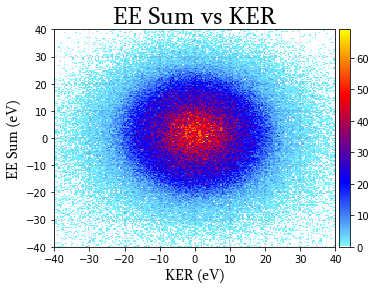

In [7]:
plt.hist2d(data.data['rpz_1'],data.data['rpy_1'],bins=200,cmap=coltrims,range=[[-40,40],[-40,40]])
plt.hist2d(data.data['rpz_2'],data.data['rpy_2'],bins=200,cmap=coltrims,range=[[-40,40],[-40,40]])
plt.hist2d(data.data['rpz_3'],data.data['rpy_3'],bins=200,cmap=coltrims,range=[[-40,40],[-40,40]])
plt.colorbar(pad = 0.01)
plt.xlabel('KER (eV)',fontname='sylfaen',fontsize=15)
plt.ylabel('EE Sum (eV)',fontname='sylfaen',fontsize=15)
plt.title('EE Sum vs KER',fontname='sylfaen',fontsize=25)
plt.grid(color='k',linestyle='dotted',linewidth=.25)

Let's import the fixed-frame data and make the same plot.

In [8]:
data = Data('fixedframe_particle_data.csv')
data.add_neutral_particle(1,2,16)

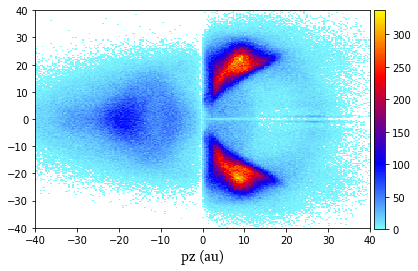

In [9]:
fig, ax = plt.subplots()
cax = fig.add_axes([.91, 0.12, 0.025, .76])

z_data = pd.Series(data.data['rpz_1']).append(pd.Series(data.data['rpz_2'])).append(pd.Series(data.data['rpz_3']))
y_data = pd.Series(data.data['rpy_1']).append(pd.Series(data.data['rpy_2'])).append(pd.Series(data.data['rpy_3']))
im = ax.hist2d(z_data,y_data,bins=200,cmap=coltrims,range=[[-40,40],[-40,40]]);
fig.colorbar(im[3], cax=cax, orientation='vertical')
ax.set_xlabel('pz (au)',fontname='sylfaen',fontsize=15);

We some some clear structure in the body-fixed momentum frame! It's mostly muddled together in blobs, so it will be hard to make decisions based on this plot alone. By definition of the coordinate system, one of the H$^+$ particles appears in the upper right quadrant, another in the lower right, while the inferred oxygen momenta appear in the left half of the figure.

### Nuclear Conformation Maps

We've already learned that we can partially select dication states out of our data by cutting based on the energy correlation plot - specifically, we can select from the three diagonal features and select all states corresponding to particular oxygen term asymptotes. How can we further separate the dication states?

For a given oxygen asymptote, each dication populates a unique potential energy surface. The kinematics of the dissociation are defined by the gradient of this potential surface. Therefor, we should expect each dication state to have unique kinematics: different kinetic energies among recoil fragments, different electron energy sums, and different angles between the fragments. Generally speaking, for a "symmetric" dissociation (such as the one captured in Fig. 2) there are three possibilities for contrasting two different potential energy surfaces:

* Both potential surfaces have the same total energy at the beginning and end of the process
* Both potential surfaces have the same total energy at the beginning, but different energy at the end
* The surfaces have different energy at the beginning, but the same energy at the end

Let's visualize this:

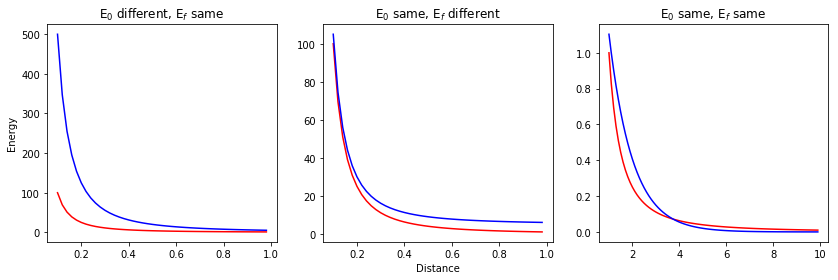

In [59]:
x = np.arange(0.1,1,.02)
y1 = 1/x**2
y2 = 5/x**2
y3 = 1/x**2 + 5

plt.figure(1,figsize=(14,4))

plt.subplot(131)
plt.plot(x,y1,'r-',x,y2,'b-');
plt.title('E$_0$ different, E$_f$ same');
plt.ylabel('Energy')

plt.subplot(132)
plt.plot(x,y1,'r-',x,y3,'b-');
plt.title('E$_0$ same, E$_f$ different');
plt.xlabel('Distance')

x = np.arange(1,10,.1)
y1 = 1/x**2
y4 = 3*np.exp(-x)
plt.subplot(133)
plt.plot(x,y1,'r-',x,y4,'b-');
plt.title('E$_0$ same, E$_f$ same');


Note that in the case where the initial energies and final energies are the same, the general *shape* of the surface need not be identical between dication states.

When a photon is absorbed, the total energy of the system increases by exactly that amount. Energy is distributed among the constituent particles based on the shape of the potential surfaces when the photoabsorption happens, as illustrated below.

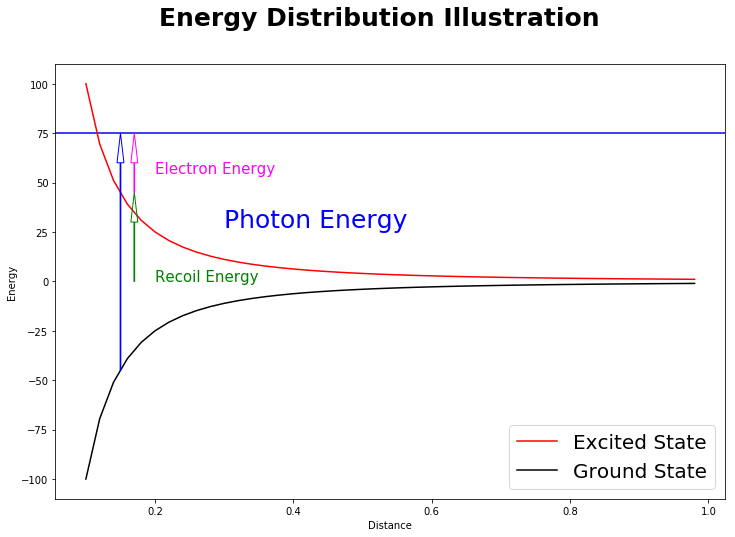

In [14]:
x = np.arange(0.1,1,.02)
y1 = 1/x**2
y2 = 5/x**2

fig = plt.figure()
fig.suptitle('Energy Distribution Illustration', fontsize=25, fontweight='bold')
fig.set_figheight(8)
fig.set_figwidth(12)
ax = fig.add_subplot(111)

ax.set_xlabel('Distance')
ax.set_ylabel('Energy')

x = np.arange(0.1,1,.02);
y1 = 1/x**2;
y2 = -1/x**2;
ax.plot(x,y1,'r-',zorder=1,label='Excited State');
ax.plot(x,y2,'k-',zorder=1,label='Ground State');
ax.axhline(y=75,color='blue',zorder=0);
ax.arrow(.15,-45,0,120,length_includes_head=True,head_width=.01,head_length=15,fill=False,color='blue');
ax.arrow(.17,0,0,45,length_includes_head=True,head_width=.01,head_length=15,fill=False,color='green');
ax.arrow(.17,45,0,30,length_includes_head=True,head_width=.01,head_length=15,fill=False,color='magenta');
ax.annotate('Recoil Energy', xy=(0.2,0),color='green',fontsize=15)
ax.annotate('Electron Energy', xy=(0.2,55),color='magenta',fontsize=15)
ax.annotate('Photon Energy', xy=(0.3,27.5),color='blue',fontsize=25)
ax.legend(fontsize=20);

Clearly, the energy distribution between recoil energy and electron energy depends on the shape of the excited state potential surface. The *total energy* depends on the asymptotic value of the potential surface, once the dication has fully dissociated. 

The simplified, illustrative discussion above was based on a system with a single degree of freedom. Namely, an unspecified "distance" variable. Only diatomic molecules exhibit such simplicity. The water molecule, which we're considering here, has *three* degrees of freedom instead of one. Accordingly, it's potential energy surfaces are more complex. Indeed, we cannot draw them. However, the discussion above suggests to us that the different dication states of the water molecule should leave molecular fragments with different amounts of kinetic energy (called the kinetic energy release, KER) depending on the dication state populated.

The same considerations used above can be applied to any degree of freedom in the molecular system. In this case, the most fruitful is $\beta$, the angle between the outgoing H$^+$ momenta. The dication states will have different angular distributions between the H$^+$ ions, depending on the shape of the dication potential surface. To investigate this, and the distribution of KERs, we plot the two variables against each other.

In [16]:
#calculate the angle between vectors
def get_angle(data):
    mag_a = np.sqrt(data['rpx_1']*data['rpx_1'] + data['rpy_1']*data['rpy_1'] + data['rpz_1']*data['rpz_1'])
    mag_b = np.sqrt(data['rpx_2']*data['rpx_2'] + data['rpy_2']*data['rpy_2'] + data['rpz_2']*data['rpz_2'])
    cos_of_angle = (data['rpx_1']*data['rpx_2'] + data['rpy_1']*data['rpy_2'] + data['rpz_1']*data['rpz_2'])/(mag_a*mag_b)
    return pd.Series({'angle_deg': np.arccos(cos_of_angle)*180./np.pi})

data.data['angle_deg'] = data.data.apply(get_angle,axis=1)

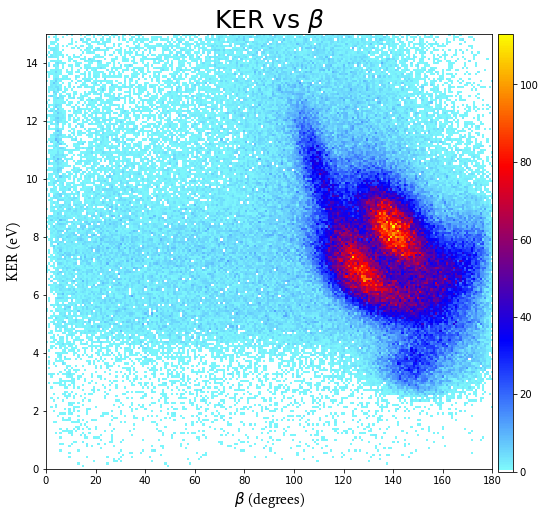

In [27]:
fig, ax = plt.subplots()
cax = fig.add_axes([.91, 0.12, 0.025, .76])
fig.set_figheight(8)
fig.set_figwidth(8)
im = ax.hist2d(data.data['angle_deg'],data.data['ker'],bins=200,cmap=coltrims,range=[[0,180],[0,15]])
fig.colorbar(im[3], cax=cax, orientation='vertical')
ax.set_xlabel(r'$\beta$ (degrees)',fontname='sylfaen',fontsize=15)
ax.set_ylabel('KER (eV)',fontname='sylfaen',fontsize=15)
ax.set_title(r'KER vs $\beta$',fontsize=25);

Features! Based on our previous efforts, we know that the structures observed in this figure almost certainly correspond to specific dication states. However, we can see perhaps four distinct structures here, but there are nine dication states. We need to slice the data more.

Fortunately, we already have a good way to slice the data. Our energy correlation plots and knowledge from Fig. 2 direct us to slice the data on total energy. Fig. 2 tells us that we should be able to isolate a single dication state, the highest $^1$A$_1$, with an appropriate gate on total energy. We guessed the total energy peak for that state was around 14.2 eV previously, so let's start there.

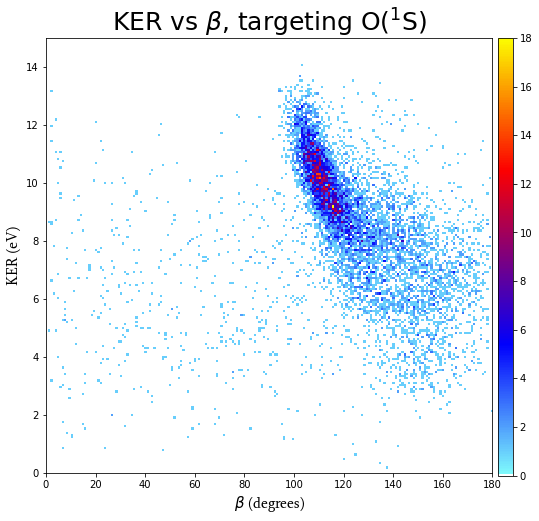

In [31]:
    fig, ax = plt.subplots()
    cax = fig.add_axes([.91, 0.12, 0.025, .76])
    fig.set_figheight(8)
    fig.set_figwidth(8)
    x = data.data[(data.data['ker'] + data.data['ee_sum'] < 14.5)&(data.data['ker'] + data.data['ee_sum'] > 13.9)]['angle_deg']
    y = data.data[(data.data['ker'] + data.data['ee_sum'] < 14.5)&(data.data['ker'] + data.data['ee_sum'] > 13.9)]['ker']
    im = ax.hist2d(x,y,bins=200,cmap=coltrims,range=[[0,180],[0,15]])
    fig.colorbar(im[3], cax=cax, orientation='vertical')
    ax.set_xlabel(r'$\beta$ (degrees)',fontname='sylfaen',fontsize=15)
    ax.set_ylabel('KER (eV)',fontname='sylfaen',fontsize=15)
    ax.set_title(r'KER vs $\beta$, targeting O($^1$S)',fontsize=25);

We require that the total energy be within $\pm$0.3 eV of our estimated median energy of 14.2 eV and, sure enough, we mostly isolate a single visible feature in the plot.

The plot of KER vs $\beta$ is a useful one, so we give it a name: **nuclear conformation map**.

We now have a rough algorithm for isolating data to specific dication states:

1. Determine the sum of the asymptotic energies for all particles
2. Match the dication states to the asymptotic states
3. Gate the data based on the asymptotic state of the targeted dication
4. Make a nuclear conformation map and identify the dication state feature
5. Gate the data based on the feature in the dication state

We've made it to step 4 thus far, but only because we chose an asymptotic state that had only a single dication contribution. What does the nuclear conformation map look like when the final state comes from more than one dication state?

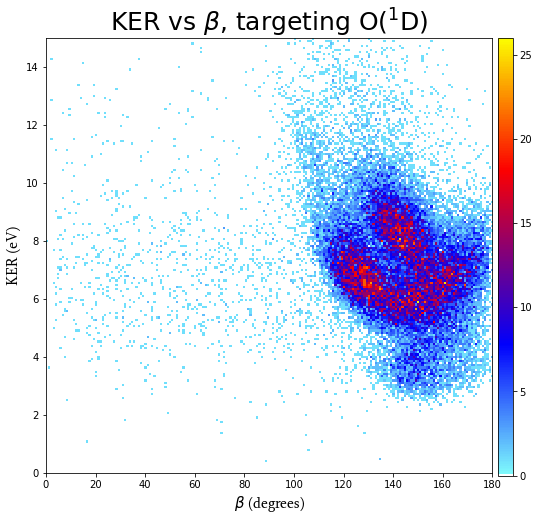

In [33]:
fig, ax = plt.subplots()
cax = fig.add_axes([.91, 0.12, 0.025, .76])
fig.set_figheight(8)
fig.set_figwidth(8)
x = data.data[(data.data['ker'] + data.data['ee_sum'] < 16.5)&(data.data['ker'] + data.data['ee_sum'] > 15.9)]['angle_deg']
y = data.data[(data.data['ker'] + data.data['ee_sum'] < 16.5)&(data.data['ker'] + data.data['ee_sum'] > 15.9)]['ker']
im = ax.hist2d(x,y,bins=200,cmap=coltrims,range=[[0,180],[0,15]])
fig.colorbar(im[3], cax=cax, orientation='vertical')
ax.set_xlabel(r'$\beta$ (degrees)',fontname='sylfaen',fontsize=15)
ax.set_ylabel('KER (eV)',fontname='sylfaen',fontsize=15)
ax.set_title(r'KER vs $\beta$, targeting O($^1$D)',fontsize=25);

Well, it still works, but now we have multiple features corresponding to multiple dication states, and no insight on how to assign specific dication states to specific features. Fortunately, theory has a lot to say on the kinematics of dissociating molecules, and can replicate our conformation maps with remarkable accuracy by calculating the potential surfaces and performing classical trajectory calculations on a population of ions.

<img src="theory_gates.png" style="width: 800px;"/>
<div align="center">
    <font size=6>Fig. 4</font>
</div>

This series of figures are pulled from my dissertation (the images were made using our theoretical collaborators simulated data and gnuplot). Let's create the sample plots in the same order, so we can see experiment and theory back-to-back. I'll also update the gates to match the recommendations of our theory collaborators.

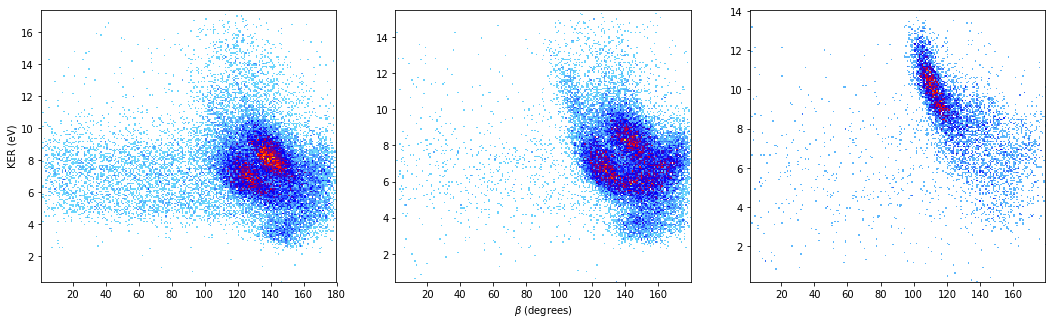

In [61]:
plt.figure(1,figsize=(18,5))
plt.subplot(131)
x = data.data['angle_deg'].where((data.data['ker'] + data.data['ee_sum'] < 17.78)&(data.data['ker'] + data.data['ee_sum'] > 17.26)).dropna()
y = data.data['ker'].where((data.data['ker'] + data.data['ee_sum'] < 17.78)&(data.data['ker'] + data.data['ee_sum'] > 17.26)).dropna()
im = plt.hist2d(x,y,bins=200,cmap=coltrims);
plt.ylabel('KER (eV)')

plt.subplot(132)
x = data.data['angle_deg'].where((data.data['ker'] + data.data['ee_sum'] < 16.07)&(data.data['ker'] + data.data['ee_sum'] > 15.56)).dropna()
y = data.data['ker'].where((data.data['ker'] + data.data['ee_sum'] < 16.07)&(data.data['ker'] + data.data['ee_sum'] > 15.56)).dropna()
im = plt.hist2d(x,y,bins=200,cmap=coltrims);
plt.xlabel(r'$\beta$ (degrees)')

plt.subplot(133)
x = data.data['angle_deg'].where((data.data['ker'] + data.data['ee_sum'] < 14.27)&(data.data['ker'] + data.data['ee_sum'] > 13.76)).dropna()
y = data.data['ker'].where((data.data['ker'] + data.data['ee_sum'] < 14.27)&(data.data['ker'] + data.data['ee_sum'] > 13.76)).dropna()
im = plt.hist2d(x,y,bins=200,cmap=coltrims);

<img src="theory_gates.png" style="width: 1100px;"/>
<div align="center">
    <font size=6>Fig. 5</font>
</div>

With guidance from theory, we are able to isolate photo double-ionization data for specific dication states. The eventual goal for this technique will be to measure the correlation between the photoelectrons for:

* Specific Dication States
* Specific Orientations of the molecule

My data set was, unfortunately, not clean enough (nor large enough) to achieve this. The major accomplishment was finding a way to isolate dication states!

###### A Note on the $^3$P Features

There is a broad, horizontal band in the nuclear conformation map, which remains only when the $^3$P asymptotic energy gate is applied. After the completion of my dissertation, some of our collaborators published a paper that suggested this stripe was due to a sequential break-up of the water dication. In other words, the H$_2$O$^{2+}$ ejects a H$^+$ ion then, after some short delay, ejects another ion. In this case, the unstable OH$^+$ ion has an opportunity to rotate a non-trivial amount before further dissociating. In such a case, the kinetic energy is unchanged, but the angle $\beta$ is effectively random afterward; hence the horizontal stripe, with a foreseeable distribution of kinetic energies and a seemingly uniform distribution of $\beta$.